In [12]:
from util_v4 import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# 0. Loading and preprocessing

In [4]:
data_dir = "C:\\Users\\DavidJIA\\Desktop\\IC RMFE\\Term 3\\Applied Macro Trading Strategy\\CourseWork\\datasets\\"
# data_dir = './'
# Load and process data
aqms_data = load_aqms_data(data_dir + 'AQMS.xlsx')
bc_data = load_business_cycle_data(data_dir + 'Business Cycle.xls')

In [5]:
# Preprocess asset data
ar, ir = preprocess_asset_data_daily(aqms_data)
mf = preprocess_macro_factors(bc_data, ar, ir)
mf = standardize_column_names(mf)
ar = standardize_column_names(ar)

# Apply transformation on ar
ar = transform_currency_returns(ar.copy())
# Apply transformation on mf
mf = create_us_centric_trade_factors(mf.copy())
mf.ffill(inplace=True)

# Segment time
ar = ar[ar.index >= '1985-01-01']

# 1. Construct portfolio

In [6]:
mp_portfolio = construct_mp_portfolio(ar, mf);

In [7]:
rs_portfolio = construct_rs_portfolio(ar, mf);

In [8]:
it_portfolio = construct_it_portfolio(ar, mf);

In [9]:
bc_portfolio = construct_bc_portfolio(ar, mf);

In [10]:
final_portfolio = integrate_portfolios(bc_portfolio, it_portfolio, mp_portfolio, rs_portfolio)

# 2. Plotting

### 2.1 Returns

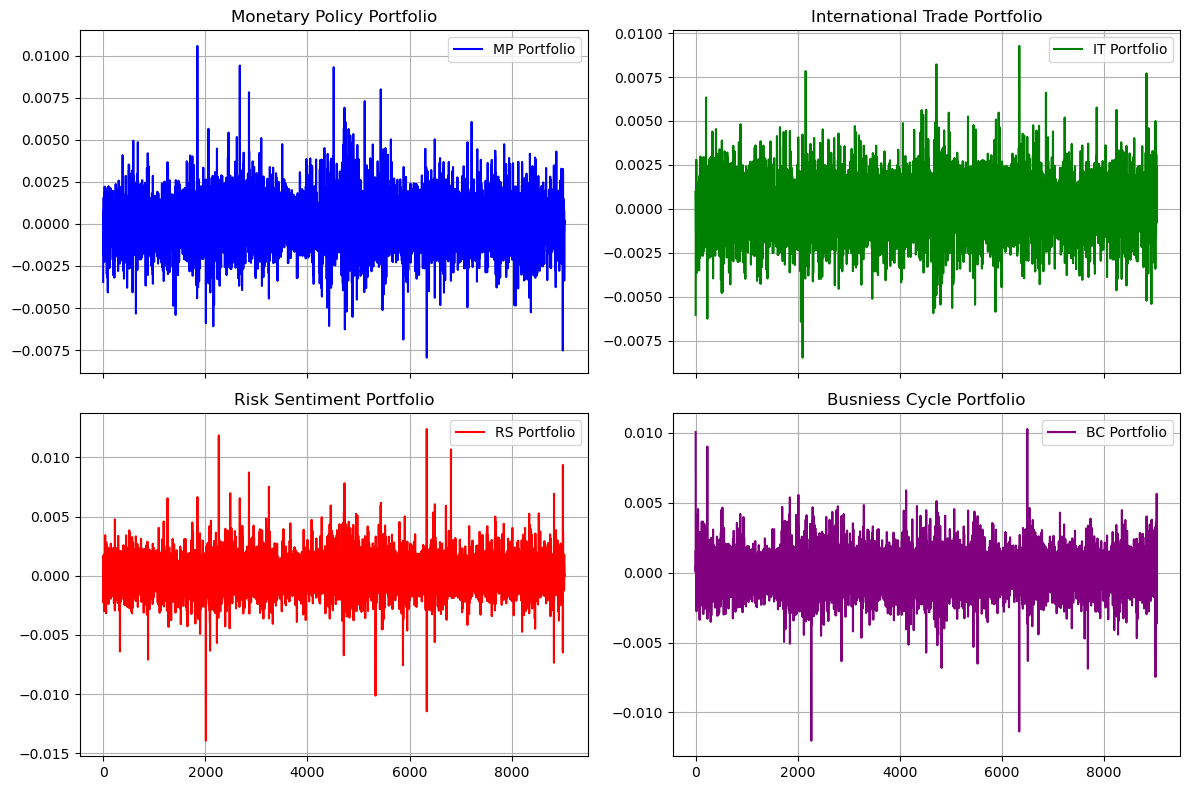

In [14]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot each series in its own subplot
axs[0, 0].plot(mp_portfolio['returns'].values[1500:], label='MP Portfolio', color='blue')
axs[0, 0].set_title('Monetary Policy Portfolio')

axs[0, 1].plot(it_portfolio['returns'].values[1500:], label='IT Portfolio', color='green')
axs[0, 1].set_title('International Trade Portfolio')

axs[1, 0].plot(rs_portfolio['returns'].values[1500:], label='RS Portfolio', color='red')
axs[1, 0].set_title('Risk Sentiment Portfolio')

axs[1, 1].plot(bc_portfolio['returns'].values[1500:], label='BC Portfolio', color='purple')
axs[1, 1].set_title('Busniess Cycle Portfolio')

# Optional: Add legends, grid and tight layout
for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### 2.2 Cumulative Returns

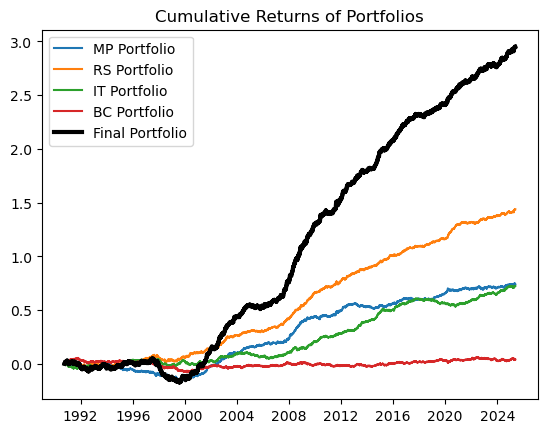

In [50]:
returns_data = [mp_portfolio['returns'].values, 
                rs_portfolio['returns'].values, 
                it_portfolio['returns'].values,
                bc_portfolio['returns'].values,
                final_portfolio['returns'].values]
returns_data = [np.nan_to_num(data, nan=0) for data in returns_data]

labels = ['MP Portfolio', 'RS Portfolio', 'IT Portfolio', 'BC Portfolio', 'Final Portfolio']
for i, data in enumerate(returns_data):
    data = np.where((data > 80) | (data < -80), 0, data)  # Replace extreme values with 0
    data = data[1500:]
    cum_returns = np.cumsum(data)

    # Use a thicker line for "Final Portfolio"
    if labels[i] == 'Final Portfolio':
        plt.plot(mp_portfolio['returns'].index[1500:], cum_returns, label=labels[i], linewidth=3, color='black')
    else:
        plt.plot(mp_portfolio['returns'].index[1500:], cum_returns, label=labels[i], linewidth=1.5)

plt.title('Cumulative Returns of Portfolios')
plt.legend()

### 2.3 Metrics

Final Portfolio Return and Cum Return

In [54]:
print("The final portfolio generates a mean annual return of:", round((1+final_portfolio['returns'].mean())**252-1, 4)*100, "%")
print("The final portfolio generates a geomean annual return of:", round( (1 + final_portfolio['returns']).prod() ** (252 / len(final_portfolio['returns'])) - 1, 4)*100, "%")
print("The final portfolio generates a annualized std of:", round(final_portfolio['returns'].std()*np.sqrt(252), 4)*100, "%")

The final portfolio generates a mean annual return of: 6.74 %
The final portfolio generates a geomean annual return of: 6.65 %
The final portfolio generates a annualized std of: 4.31 %


Max Drawdown

In [59]:
# Step 1: Convert daily returns to cumulative returns
cumulative = (1 + final_portfolio['returns']).cumprod()

# Step 2: Resample to get year-start and year-end values
year_start = cumulative.resample('Y').first()
year_end = cumulative.resample('Y').last()

# Step 3: Compute annual drawdowns
annual_drawdowns = (year_end / year_start - 1).squeeze()

# Step 4: Find the year with the maximum (most negative) drawdown
worst_year = annual_drawdowns.idxmin()
worst_drawdown = annual_drawdowns.min()

print(f"Worst year: {worst_year.year}, Max Drawdown: {worst_drawdown:.2%}")

Worst year: 1998, Max Drawdown: -10.91%


Sharpe, Sortino and Information Ratios 

In [82]:
# Sharpe & Sortino
rf_daily = (1 + aqms_data['Interest Rates_FDTR Index']/100) ** (1/252) - 1
er_rf = final_portfolio['returns'] - rf_daily
sharpe_ratio = er_rf.mean() / er_rf.std() * np.sqrt(252)

downside_returns = er_rf[er_rf < 0]
downside_std = downside_returns.std()
sortino_ratio = er_rf.mean() / downside_std * np.sqrt(252)

# Information ratio
er_sp = final_portfolio['returns'] - ar['Equity_US']
er_gb = final_portfolio['returns'] - (1 + aqms_data['Bond Yield 2Y_USGG2YR Index']/100) ** (1/252) + 1
info_ratio_sp = er_sp.mean() / er_sp.std() * np.sqrt(252)
info_ratio_gb = er_gb.mean() / er_gb.std() * np.sqrt(252)

print(f"Performance Metrics for Final Portfolio:\n"
      f"----------------------------------------\n"
      f"Sharpe Ratio    : {sharpe_ratio:.3f}\n"
      f"Sortino Ratio   : {sortino_ratio:.3f}\n"
      f"Information Ratio vs S&P500 : {info_ratio_sp:.3f}\n"
      f"Information Ratio vs US2YTB : {info_ratio_gb:.3f}")

Performance Metrics for Final Portfolio:
----------------------------------------
Sharpe Ratio    : 0.721
Sortino Ratio   : 1.103
Information Ratio vs S&P500 : -0.197
Information Ratio vs US2YTB : 0.650
